In [1]:

import lightgbm as lgb # MODIFICATION
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
import mlflow.sklearn
import os
import joblib
import shap
import pickle
import faiss

from itertools import product

from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm  

from xgboost import XGBClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)


c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# FONCTION D'UTILISATION DES MODELES

In [2]:
def clean_feature_names(X):
    import re
    # Copie du DataFrame
    X_clean = X.copy()
    
    # Nettoyer les noms de colonnes
    new_columns = {}
    for col in X_clean.columns:
        # Remplacer les caractères spéciaux par des underscores
        new_col = re.sub(r'[^A-Za-z0-9_]+', '_', str(col))
        # Éviter les underscores doubles
        new_col = re.sub(r'_+', '_', new_col)
        # Enlever les underscores au début et à la fin
        new_col = new_col.strip('_')
        new_columns[col] = new_col
    
    # Renommer les colonnes
    X_clean = X_clean.rename(columns=new_columns)
    return X_clean


In [3]:

def custom_credit_score(y_true, y_pred, fn_weight=10, fp_weight=1):
    # Calculer la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculer la précision et le recall avec les poids
    weighted_precision = tp / (tp + fp_weight * fp) if (tp + fp_weight * fp) > 0 else 0
    weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
    
    # Calculer le F1-score pondéré
    if weighted_precision + weighted_recall > 0:
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    else:
        weighted_f1 = 0
        
    return weighted_f1


In [4]:

def train_and_evaluate_model(
    model,
    X_train_scaled, 
    X_test_scaled, 
    y_train, 
    y_test, 
    model_params={},
    seuil=0.36,
    experiment_name="Credit Scoring Model",
    name=None
):
    if isinstance(model, LGBMClassifier):
        X_train_scaled = clean_feature_names(X_train_scaled)
        X_test_scaled = clean_feature_names(X_test_scaled)
        
    if mlflow.active_run():
        mlflow.end_run()
    
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=name if name else f'{type(model).__name__}_'+str(len(X_train_scaled.columns.tolist()))+'_features') as run:
        mlflow.log_param("model_type", type(model).__name__)
        mlflow.log_params(model_params)
        mlflow.log_param("threshold", seuil)
        
        # Entraîner le modèle
        model.set_params(**model_params)
        model.fit(X_train_scaled, y_train)
        
        # Prédictions
        y_prob = model.predict_proba(X_test_scaled)
        y_pred = (y_prob[:, 1] >= seuil).astype(int)
        
        # Calculer les métriques
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc_score': roc_auc_score(y_test, y_prob[:, 1]),
            'custom_credit_score': custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1)
        }
        
        # Enregistrer les métriques
        mlflow.log_metrics(metrics)
        
        # Enregistrer le modèle
        mlflow.sklearn.log_model(model, f"model_{type(model).__name__}")
        
        print(f"\nRésultats pour {type(model).__name__}:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")
            
        return model, metrics, run.info.run_id

In [5]:
def custom_f1_score(y_true, y_pred, fn_weight=10, fp_weight=1):
    # Calcul de la matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul de la précision et du recall pondérés
    weighted_precision = tp / (tp + fp_weight * fp) if (tp + fp_weight * fp) > 0 else 0
    weighted_recall = tp / (tp + fn_weight * fn) if (tp + fn_weight * fn) > 0 else 0
    
    # Calcul du F1-score pondéré
    if weighted_precision + weighted_recall > 0:
        weighted_f1 = 2 * (weighted_precision * weighted_recall) / (weighted_precision + weighted_recall)
    else:
        weighted_f1 = 0
        
    return weighted_f1

In [6]:
def calculer_metriques(y_true, y_pred, y_prob):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_prob[:, 1])  # AUC utilise les probabilités
    }

In [7]:
# Fonction de test des seuils
def test_thresholds(model, X_test, y_test, start=0.2, end=0.5, step=0.01):
    # Obtenir les probabilités
    y_prob = model.predict_proba(X_test)
    
    thresholds = np.arange(start, end + step, step)
    results = []
    
    for threshold in thresholds:
        # Appliquer le seuil
        y_pred = (y_prob[:, 1] >= threshold).astype(int)
        
        # Calculer toutes les métriques
        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'custom_credit_score': custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1)
        }
        results.append(metrics)
    
    # Convertir en DataFrame pour une meilleure visualisation
    results_df = pd.DataFrame(results)
    
    # Trouver le meilleur seuil pour chaque métrique
    best_thresholds = {
        'accuracy': results_df.loc[results_df['accuracy'].idxmax(), 'threshold'],
        'recall': results_df.loc[results_df['recall'].idxmax(), 'threshold'],
        'f1_score': results_df.loc[results_df['f1_score'].idxmax(), 'threshold'],
        'custom_credit_score': results_df.loc[results_df['custom_credit_score'].idxmax(), 'threshold']
    }
    
    return results_df, best_thresholds

In [8]:
def custom_lgb_score(preds, train_data):
    y_true = train_data.get_label()
    y_pred = (preds >= 0.34).astype(int)
    score = custom_credit_score(y_true, y_pred, fn_weight=10, fp_weight=1)
    return 'custom_credit_score', score, True

In [9]:
def faiss_knn_imputer(X, n_neighbors=5, use_gpu=False):
    """
    Impute les valeurs manquantes en utilisant FAISS pour KNN
    
    Args:
        X: DataFrame avec valeurs manquantes (déjà scalées)
        n_neighbors: Nombre de voisins à utiliser
        use_gpu: Utiliser GPU si disponible
        
    Returns:
        DataFrame avec valeurs imputées
    """
    # Créer une copie pour le résultat
    X_imputed = X.copy()
    
    # Pour chaque colonne avec des valeurs manquantes
    for col in tqdm(X.columns, desc="Imputation des colonnes"):
        # Vérifier s'il y a des valeurs manquantes
        mask_missing = X[col].isna()
        if not mask_missing.any():
            continue
            
        # Obtenir les indices des observations avec valeurs manquantes et non manquantes
        missing_indices = np.where(mask_missing)[0]
        valid_indices = np.where(~mask_missing)[0]
        
        if len(valid_indices) == 0:
            print(f"Impossible d'imputer la colonne {col}: pas de valeurs valides")
            continue
            
        # Extraire les caractéristiques pour l'entraînement (observations sans valeur manquante pour cette colonne)
        X_train = X.iloc[valid_indices].drop(col, axis=1).fillna(0).values.astype('float32')
        y_train = X.iloc[valid_indices][col].values.astype('float32')
        
        # Extraire les caractéristiques pour la prédiction (observations avec valeur manquante pour cette colonne)
        X_predict = X.iloc[missing_indices].drop(col, axis=1).fillna(0).values.astype('float32')
        
        # Construire l'index FAISS
        dimension = X_train.shape[1]
        
        if use_gpu and faiss.get_num_gpus() > 0:
            res = faiss.StandardGpuResources()
            index = faiss.IndexFlatL2(dimension)
            index = faiss.index_cpu_to_gpu(res, 0, index)
        else:
            index = faiss.IndexFlatL2(dimension)
        
        # Ajouter les données d'entraînement à l'index
        index.add(X_train)
        
        # Rechercher les plus proches voisins
        D, I = index.search(X_predict, min(n_neighbors, len(X_train)))
        
        # Calculer les moyennes des valeurs des voisins pour chaque observation
        imputed_values = np.zeros(len(missing_indices))
        for i in range(len(missing_indices)):
            neighbors = I[i]
            # Filtrer les voisins invalides (-1)
            valid_neighbors = neighbors[neighbors != -1]
            if len(valid_neighbors) > 0:
                imputed_values[i] = np.mean(y_train[valid_neighbors])
            else:
                # Cas rare: aucun voisin trouvé
                imputed_values[i] = np.mean(y_train)
        
        # Mettre à jour les valeurs manquantes dans le DataFrame
        X_imputed.loc[mask_missing, col] = imputed_values
    
    return X_imputed

# FIN FONCTIONS


J'ai modifié plusieurs lignes de ce notebook du à des dépréciations depuis sa création

In [10]:
DF_results = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\submission_kernel02.csv')

In [11]:
DF_results

,SK_ID_CURR,TARGET
0,100001,0.033534
1,100005,0.146321
2,100013,0.029158
3,100028,0.036100
4,100038,0.147196
...,...,...
48739,456221,0.045465
48740,456222,0.060997
48741,456223,0.007718
48742,456224,0.025056


Les résultats obtenus sont des probabilités. Probabilités du client de ne pas rembourser le crédit

In [12]:
DF_final = pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\full_dataset.csv')

In [13]:
DF_final.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  356251 non-null  int64  
 1    SK_ID_CURR                                                             356251 non-null  int64  
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            356251 non-null  int64  
 4    FLAG_OWN_CAR                                                           356251 non-null  int64  
 5    FLAG_OWN_REALTY                                                        356251 non-null  int64  
 6    CNT_CHILDREN                                                      

In [14]:
DF_final = clean_feature_names(DF_final)

In [15]:
DF_final.describe()

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWa

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
count,356251.000000,356251.000000,307507.00000,356251.000000,356251.000000,356251.000000,356251.000000,3.562510e+05,3.562510e+05,356215.000000,...,102866.000000,103558.000000,1.035580e+05,103558.000000,103558.000000,103558.000000,103558.000000,103558.000000,103558.0,103558.000000
mean,136052.869904,278128.870078,0.08073,0.660001,0.339699,0.306764,0.414312,1.701159e+05,5.877695e+05,27425.644390,...,66.276536,0.963567,5.316636e-07,0.032644,0.000143,0.000002,0.000059,0.003583,0.0,37.083683
std,93841.582375,102842.068890,0.27242,0.473709,0.473608,0.461151,0.720376,2.235080e+05,3.986253e+05,14732.860946,...,6110.026303,0.114345,7.659438e-05,0.109727,0.010525,0.000156,0.000846,0.031014,0.0,33.483627
min,0.000000,100001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,44532.000000,189065.500000,0.00000,0.000000,0.000000,0.000000,0.000000,1.125000e+05,2.700000e+05,16731.000000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10.000000
50%,129384.000000,278129.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.530000e+05,5.002110e+05,25078.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.000000
75%,218447.500000,367192.500000,0.00000,1.000000,1.000000,1.000000,1.000000,2.025000e+05,7.975575e+05,34960.500000,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,75.000000
max,307510.000000,456255.000000,1.00000,1.000000,1.000000,1.000000,20.000000,1.170000e+08,4.050000e+06,258025.500000,...,845673.427019,1.000000,1.190476e-02,1.000000,1.000000,0.013889,0.024390,1.000000,0.0,192.000000


In [16]:
DF_final_test = DF_final.loc[DF_final['TARGET'].isna()]

In [17]:
DF_final_train = DF_final.loc[~DF_final['TARGET'].isna()]


In [18]:
DF_final_train.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 0 to 307506
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    index                                                                  307507 non-null  int64  
 1    SK_ID_CURR                                                             307507 non-null  int64  
 2    TARGET                                                                 307507 non-null  float64
 3    CODE_GENDER                                                            307507 non-null  int64  
 4    FLAG_OWN_CAR                                                           307507 non-null  int64  
 5    FLAG_OWN_REALTY                                                        307507 non-null  int64  
 6    CNT_CHILDREN                                                           

In [19]:
DF_final_train = DF_final_train.drop('index',axis=1)

In [20]:
DF_final_train['SK_ID_CURR'] = DF_final_train['SK_ID_CURR'].astype(int)

In [21]:
DF_final_train = DF_final_train.set_index('SK_ID_CURR')

In [22]:
DF_final_test.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 307507 to 356250
Data columns (total 766 columns):
 #    Column                                                                 Non-Null Count  Dtype  
---   ------                                                                 --------------  -----  
 0    index                                                                  48744 non-null  int64  
 1    SK_ID_CURR                                                             48744 non-null  int64  
 2    TARGET                                                                 0 non-null      float64
 3    CODE_GENDER                                                            48744 non-null  int64  
 4    FLAG_OWN_CAR                                                           48744 non-null  int64  
 5    FLAG_OWN_REALTY                                                        48744 non-null  int64  
 6    CNT_CHILDREN                                                           4874

In [23]:
DF_final_test = DF_final_test.drop('index',axis=1)

In [24]:
DF_final_test['SK_ID_CURR'] = DF_final_test['SK_ID_CURR'].astype(int)

In [25]:
DF_final_test = DF_final_test.set_index('SK_ID_CURR')

In [26]:
DF_final_train.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# TRAITEMENT DES NAN


In [27]:
for col in DF_final_train.columns:
    if col != 'TARGET':
        DF_final_train.loc[DF_final_train[col].isna(), col] = DF_final_train[col].mean()

In [28]:
for col in DF_final_test.columns:
    if col != 'TARGET':
        DF_final_test.loc[DF_final_test[col].isna(), col] = DF_final_test[col].mean()

In [29]:
DF_final_train.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    TARGET                                                                 307507 non-null  float64
 1    CODE_GENDER                                                            307507 non-null  float64
 2    FLAG_OWN_CAR                                                           307507 non-null  float64
 3    FLAG_OWN_REALTY                                                        307507 non-null  float64
 4    CNT_CHILDREN                                                           307507 non-null  float64
 5    AMT_INCOME_TOTAL                                                       307507 non-null  float64
 6    AMT_CREDIT                                                        

In [30]:
DF_final_test.info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 100001 to 456250
Data columns (total 764 columns):
 #    Column                                                                 Non-Null Count  Dtype  
---   ------                                                                 --------------  -----  
 0    TARGET                                                                 0 non-null      float64
 1    CODE_GENDER                                                            48744 non-null  float64
 2    FLAG_OWN_CAR                                                           48744 non-null  float64
 3    FLAG_OWN_REALTY                                                        48744 non-null  float64
 4    CNT_CHILDREN                                                           48744 non-null  float64
 5    AMT_INCOME_TOTAL                                                       48744 non-null  float64
 6    AMT_CREDIT                                                             4874

In [31]:
# Séparation features (X) et target (y)
X = DF_final_train.drop('TARGET', axis=1)
y = DF_final_train['TARGET']


In [32]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X[col] == np.inf).any() or (X[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X[col] = X[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X[col] = X[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['PREV_APP_CREDIT_PERC_MAX', 'PREV_APP_CREDIT_PERC_MEAN', 'REFUSED_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [33]:
X.to_csv('DF_final_train.csv', index=True)

In [34]:
X.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605


In [35]:
pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\DF_final_train.csv',index_col='SK_ID_CURR').info(show_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 763 columns):
 #    Column                                                                 Non-Null Count   Dtype  
---   ------                                                                 --------------   -----  
 0    CODE_GENDER                                                            307507 non-null  float64
 1    FLAG_OWN_CAR                                                           307507 non-null  float64
 2    FLAG_OWN_REALTY                                                        307507 non-null  float64
 3    CNT_CHILDREN                                                           307507 non-null  float64
 4    AMT_INCOME_TOTAL                                                       307507 non-null  float64
 5    AMT_CREDIT                                                             307507 non-null  float64
 6    AMT_ANNUITY                                                       

In [36]:
pd.read_csv(r'C:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\DF_final_train.csv',index_col='SK_ID_CURR').head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_SK_DPD_DEF_VAR,CC_NAME_CONTRACT_STATUS_Active_MEAN,CC_NAME_CONTRACT_STATUS_Approved_MEAN,CC_NAME_CONTRACT_STATUS_Completed_MEAN,CC_NAME_CONTRACT_STATUS_Demand_MEAN,CC_NAME_CONTRACT_STATUS_Refused_MEAN,CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605
100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,...,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,6.000000
100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,...,55.251006,0.966911,6.335426e-07,0.029179,0.000106,0.000002,0.000064,0.003738,0.0,37.143605


In [37]:

# 1. Séparation train/test stratifiée
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# 2. Scaling avec conservation de l'index
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    index=X_train.index,
    columns=X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    index=X_test.index,
    columns=X_test.columns
)

# 3. Modèle avec pondération
model = LogisticRegression(
    class_weight={0:1, 1:10},
    random_state=42
)

# 4. Validation croisée stratifiée
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = []
for train_idx, val_idx in skf.split(X_train_scaled, y_train):
    # Conversion en array numpy pour éviter les problèmes d'index
    X_train_fold = X_train_scaled.iloc[train_idx].values
    y_train_fold = y_train.iloc[train_idx].values
    X_val_fold = X_train_scaled.iloc[val_idx].values
    y_val_fold = y_train.iloc[val_idx].values
    
    # Entraînement et évaluation
    model.fit(X_train_fold, y_train_fold)
    score = model.score(X_val_fold, y_val_fold)
    scores.append(score)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

In [38]:
scores

[0.7402898315074897,
 0.736550070120526,
 0.740452429828662,
 0.7427491311152212,
 0.7398426861242657]

In [39]:
model_final = LogisticRegression(class_weight={0:1, 1:10}, random_state=42)
model_final.fit(X_train_scaled, y_train)

c:\Users\lenovo\Desktop\OpenClassrooms\PROJET_OC\PROJET_7\PROJET_7\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight={0: 1, 1: 10}, random_state=42)

In [40]:
X_pred = DF_final_test.drop('TARGET',axis = 1)

In [41]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")
print(X_pred.dtypes)

# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X_pred.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X_pred[col] == np.inf).any() or (X_pred[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X_pred[col] = X_pred[col].replace([np.inf, -np.inf], np.nan)
    # Remplacer les NaN par la moyenne
    X_pred[col] = X_pred[col].fillna(X[col].mean())

Types de données dans X :
CODE_GENDER                                   float64
FLAG_OWN_CAR                                  float64
FLAG_OWN_REALTY                               float64
CNT_CHILDREN                                  float64
AMT_INCOME_TOTAL                              float64
                                               ...   
CC_NAME_CONTRACT_STATUS_Refused_MEAN          float64
CC_NAME_CONTRACT_STATUS_Sent_proposal_MEAN    float64
CC_NAME_CONTRACT_STATUS_Signed_MEAN           float64
CC_NAME_CONTRACT_STATUS_nan_MEAN              float64
CC_COUNT                                      float64
Length: 763, dtype: object

Colonnes avec des infinis :
['INSTAL_PAYMENT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_SUM']


In [42]:
X_pred_scaled = pd.DataFrame(
    scaler.transform(X_pred),
    index=X_pred.index,
    columns=X_pred.columns
)

In [43]:
y_pred = model_final.predict(X_test_scaled)

In [44]:
y_pred

array([0., 0., 1., ..., 0., 0., 1.])

In [45]:
y_prob = model_final.predict_proba(X_test_scaled)

In [46]:
y_prob

array([[0.58571013, 0.41428987],
       [0.6838494 , 0.3161506 ],
       [0.49940212, 0.50059788],
       ...,
       [0.81460964, 0.18539036],
       [0.72666552, 0.27333448],
       [0.31718763, 0.68281237]])

# ANALYSE DES CLIENTS DEFAILLANTS MAL CLASSES AINSI QUE DE LEUR PROBA RESPECTIVES 

In [47]:
# Obtenir les prédictions et probabilités
y_pred = model_final.predict(X_test_scaled)
y_prob = model_final.predict_proba(X_test_scaled)

# Créer un DataFrame pour l'analyse
results_df = pd.DataFrame({
    'Vraie_Classe': y_test,
    'Prediction': y_pred,
    'Probabilite_Defaut': y_prob[:, 1]  # Probabilité de la classe 1 (défaillant)
})

# Identifier les faux négatifs (clients défaillants classés comme non-défaillants)
faux_negatifs = results_df[
    (results_df['Vraie_Classe'] == 1) & 
    (results_df['Prediction'] == 0)
].sort_values('Probabilite_Defaut', ascending=False)

print("Nombre de faux négatifs:", len(faux_negatifs))
print("\nDétail des faux négatifs:")
print(faux_negatifs.head(10))  # Afficher les 10 premiers cas

Nombre de faux négatifs: 1714

Détail des faux négatifs:
            Vraie_Classe  Prediction  Probabilite_Defaut
SK_ID_CURR                                              
374327               1.0         0.0            0.499804
432883               1.0         0.0            0.499570
335164               1.0         0.0            0.499455
200764               1.0         0.0            0.499430
183259               1.0         0.0            0.499160
369928               1.0         0.0            0.499012
327081               1.0         0.0            0.498872
149442               1.0         0.0            0.498457
250360               1.0         0.0            0.498435
351862               1.0         0.0            0.498420


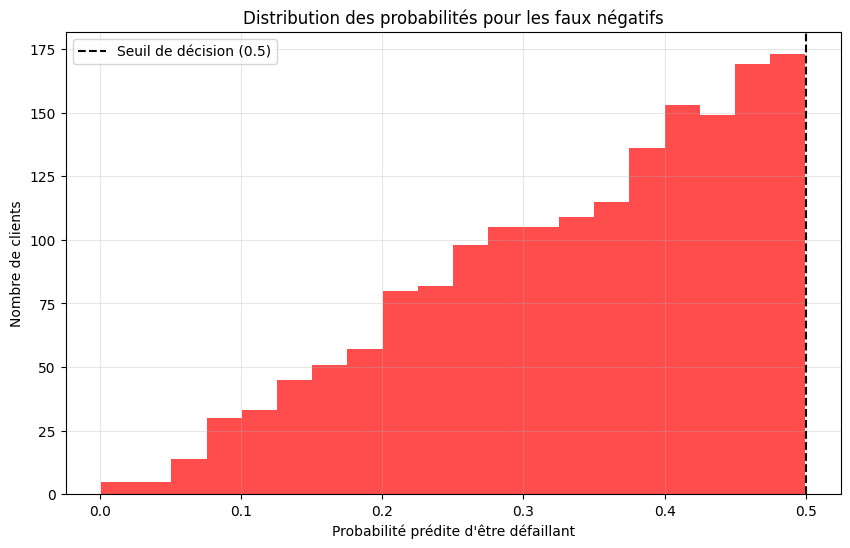

In [48]:

plt.figure(figsize=(10, 6))
plt.hist(faux_negatifs['Probabilite_Defaut'], bins=20, color='red', alpha=0.7)
plt.title('Distribution des probabilités pour les faux négatifs')
plt.xlabel('Probabilité prédite d\'être défaillant')
plt.ylabel('Nombre de clients')
plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil de décision (0.5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# TEST DE DIFFERENTES VALEURS DE SEUIL AVEC RECALL COMME METRIQUE

In [49]:
# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du recall
    recall = recall_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'recall': recall
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, Recall: {res['recall']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['recall'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un recall de {meilleur_seuil['recall']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, Recall: 0.9519
Seuil: 0.21, Recall: 0.9460
Seuil: 0.22, Recall: 0.9392
Seuil: 0.23, Recall: 0.9323
Seuil: 0.24, Recall: 0.9275
Seuil: 0.25, Recall: 0.9192
Seuil: 0.26, Recall: 0.9130
Seuil: 0.27, Recall: 0.9031
Seuil: 0.28, Recall: 0.8947
Seuil: 0.29, Recall: 0.8858
Seuil: 0.30, Recall: 0.8781
Seuil: 0.31, Recall: 0.8697
Seuil: 0.32, Recall: 0.8608
Seuil: 0.33, Recall: 0.8522
Seuil: 0.34, Recall: 0.8403
Seuil: 0.35, Recall: 0.8350
Seuil: 0.36, Recall: 0.8264
Seuil: 0.37, Recall: 0.8159
Seuil: 0.38, Recall: 0.8056
Seuil: 0.39, Recall: 0.7946
Seuil: 0.40, Recall: 0.7845
Seuil: 0.41, Recall: 0.7724
Seuil: 0.42, Recall: 0.7595
Seuil: 0.43, Recall: 0.7486
Seuil: 0.44, Recall: 0.7364
Seuil: 0.45, Recall: 0.7235
Seuil: 0.46, Recall: 0.7108
Seuil: 0.47, Recall: 0.6953
Seuil: 0.48, Recall: 0.6822
Seuil: 0.49, Recall: 0.6703
Seuil: 0.50, Recall: 0.6548

Meilleur seuil: 0.20 avec un recall de 0.9519

Matrice de confusion avec le meilleur seuil:
[[15277 41260]
 [  239  4726]]


# MEME CHOSE MAIS AVEC LE F1 SCORE

In [50]:
# Obtenir les probabilités de prédiction
y_prob = model_final.predict_proba(X_test_scaled)

# Tester différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    # Prédictions avec le seuil actuel
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    # Calcul du F1-score
    f1 = f1_score(y_test, y_pred)
    resultats.append({
        'seuil': seuil,
        'f1_score': f1
    })

# Afficher les résultats pour chaque seuil
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score: {res['f1_score']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['f1_score'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score de {meilleur_seuil['f1_score']:.4f}")

# Sauvegarder le meilleur modèle (avec son seuil)
meilleur_modele = {
    'model': model_final,
    'seuil': meilleur_seuil['seuil']
}

# Faire les prédictions avec le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score: 0.1855
Seuil: 0.21, F1-Score: 0.1886
Seuil: 0.22, F1-Score: 0.1916
Seuil: 0.23, F1-Score: 0.1948
Seuil: 0.24, F1-Score: 0.1985
Seuil: 0.25, F1-Score: 0.2020
Seuil: 0.26, F1-Score: 0.2054
Seuil: 0.27, F1-Score: 0.2083
Seuil: 0.28, F1-Score: 0.2116
Seuil: 0.29, F1-Score: 0.2150
Seuil: 0.30, F1-Score: 0.2186
Seuil: 0.31, F1-Score: 0.2220
Seuil: 0.32, F1-Score: 0.2256
Seuil: 0.33, F1-Score: 0.2293
Seuil: 0.34, F1-Score: 0.2324
Seuil: 0.35, F1-Score: 0.2373
Seuil: 0.36, F1-Score: 0.2413
Seuil: 0.37, F1-Score: 0.2449
Seuil: 0.38, F1-Score: 0.2484
Seuil: 0.39, F1-Score: 0.2519
Seuil: 0.40, F1-Score: 0.2561
Seuil: 0.41, F1-Score: 0.2601
Seuil: 0.42, F1-Score: 0.2633
Seuil: 0.43, F1-Score: 0.2677
Seuil: 0.44, F1-Score: 0.2710
Seuil: 0.45, F1-Score: 0.2745
Seuil: 0.46, F1-Score: 0.2777
Seuil: 0.47, F1-Score: 0.2802
Seuil: 0.48, F1-Score: 0.2837
Seuil: 0.49, F1-Score: 0.2876
Seuil: 0.50, F1-Score: 0.2899

Meilleur seuil: 0.50 avec un F1-Score de 0.2899

Matrice de confusion

# MEME CHOSE AVEC UN F1 SCORE PONDERE

In [51]:
# Test des différents seuils avec le F1-score pondéré
y_prob = model_final.predict_proba(X_test_scaled)
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    weighted_f1 = custom_f1_score(y_test, y_pred, fn_weight=10, fp_weight=1)
    resultats.append({
        'seuil': seuil,
        'weighted_f1': weighted_f1
    })

# Afficher les résultats
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}, F1-Score pondéré: {res['weighted_f1']:.4f}")

# Trouver le meilleur seuil
meilleur_seuil = max(resultats, key=lambda x: x['weighted_f1'])
print(f"\nMeilleur seuil: {meilleur_seuil['seuil']:.2f} avec un F1-Score pondéré de {meilleur_seuil['weighted_f1']:.4f}")

# Matrice de confusion pour le meilleur seuil
meilleures_predictions = (y_prob[:, 1] >= meilleur_seuil['seuil']).astype(int)
conf_matrix = confusion_matrix(y_test, meilleures_predictions)
print("\nMatrice de confusion avec le meilleur seuil:")
print(conf_matrix)

Seuil: 0.20, F1-Score pondéré: 0.1780
Seuil: 0.21, F1-Score pondéré: 0.1799
Seuil: 0.22, F1-Score pondéré: 0.1815
Seuil: 0.23, F1-Score pondéré: 0.1831
Seuil: 0.24, F1-Score pondéré: 0.1856
Seuil: 0.25, F1-Score pondéré: 0.1870
Seuil: 0.26, F1-Score pondéré: 0.1888
Seuil: 0.27, F1-Score pondéré: 0.1892
Seuil: 0.28, F1-Score pondéré: 0.1903
Seuil: 0.29, F1-Score pondéré: 0.1911
Seuil: 0.30, F1-Score pondéré: 0.1923
Seuil: 0.31, F1-Score pondéré: 0.1931
Seuil: 0.32, F1-Score pondéré: 0.1938
Seuil: 0.33, F1-Score pondéré: 0.1945
Seuil: 0.34, F1-Score pondéré: 0.1939
Seuil: 0.35, F1-Score pondéré: 0.1959
Seuil: 0.36, F1-Score pondéré: 0.1965
Seuil: 0.37, F1-Score pondéré: 0.1961
Seuil: 0.38, F1-Score pondéré: 0.1957
Seuil: 0.39, F1-Score pondéré: 0.1948
Seuil: 0.40, F1-Score pondéré: 0.1945
Seuil: 0.41, F1-Score pondéré: 0.1934
Seuil: 0.42, F1-Score pondéré: 0.1915
Seuil: 0.43, F1-Score pondéré: 0.1906
Seuil: 0.44, F1-Score pondéré: 0.1887
Seuil: 0.45, F1-Score pondéré: 0.1865
Seuil: 0.46,

In [52]:
# Test des différents seuils
seuils = np.arange(0.2, 0.51, 0.01)
resultats = []

# L'AUC sera constant car il ne dépend pas du seuil
auc_score = roc_auc_score(y_test, y_prob[:, 1])

for seuil in seuils:
    y_pred = (y_prob[:, 1] >= seuil).astype(int)
    metriques = calculer_metriques(y_test, y_pred, y_prob)
    resultats.append({
        'seuil': seuil,
        **metriques
    })

# Afficher les résultats
print(f"AUC global (indépendant du seuil): {auc_score:.4f}\n")
print("Résultats par seuil :")
for res in resultats:
    print(f"Seuil: {res['seuil']:.2f}")
    print(f"  Accuracy: {res['accuracy']:.4f}")
    print(f"  Recall:   {res['recall']:.4f}")
    print(f"  F1-Score: {res['f1']:.4f}")
    print()

AUC global (indépendant du seuil): 0.7729

Résultats par seuil :
Seuil: 0.20
  Accuracy: 0.3252
  Recall:   0.9519
  F1-Score: 0.1855

Seuil: 0.21
  Accuracy: 0.3427
  Recall:   0.9460
  F1-Score: 0.1886

Seuil: 0.22
  Accuracy: 0.3604
  Recall:   0.9392
  F1-Score: 0.1916

Seuil: 0.23
  Accuracy: 0.3777
  Recall:   0.9323
  F1-Score: 0.1948

Seuil: 0.24
  Accuracy: 0.3955
  Recall:   0.9275
  F1-Score: 0.1985

Seuil: 0.25
  Accuracy: 0.4136
  Recall:   0.9192
  F1-Score: 0.2020

Seuil: 0.26
  Accuracy: 0.4297
  Recall:   0.9130
  F1-Score: 0.2054

Seuil: 0.27
  Accuracy: 0.4457
  Recall:   0.9031
  F1-Score: 0.2083

Seuil: 0.28
  Accuracy: 0.4619
  Recall:   0.8947
  F1-Score: 0.2116

Seuil: 0.29
  Accuracy: 0.4777
  Recall:   0.8858
  F1-Score: 0.2150

Seuil: 0.30
  Accuracy: 0.4932
  Recall:   0.8781
  F1-Score: 0.2186

Seuil: 0.31
  Accuracy: 0.5080
  Recall:   0.8697
  F1-Score: 0.2220

Seuil: 0.32
  Accuracy: 0.5228
  Recall:   0.8608
  F1-Score: 0.2256

Seuil: 0.33
  Accuracy: 0

In [53]:
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarder le modèle et le scaler
joblib.dump(model_final, 'models/credit_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

['models/scaler.joblib']

# TEST DE DIFFERENTS MODELES

In [54]:
# Configuration de MLflow
mlflow.set_tracking_uri("http://localhost:5000")

# Liste des modèles à tester
models_to_test = [
    # 1. Dummy Classifier (baseline)
    (DummyClassifier, {'strategy': 'stratified', 'random_state': 42}),
    
    # 2. Logistic Regression 
    (LogisticRegression, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'max_iter': 1000,
        'solver': 'lbfgs'
    }),
    
    # 3. Decision Tree
    (DecisionTreeClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'max_depth': 6,
        'min_samples_split': 10
    }),
    
    # 4. Random Forest
    (RandomForestClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'n_estimators': 100,
        'max_depth': 10,
        'min_samples_split': 10,
        'n_jobs': -1
    }),
    
    # 5. XGBoost
    (XGBClassifier, {
        'scale_pos_weight': 10,
        'random_state': 42,
        'learning_rate': 0.1,
        'max_depth': 6,
        'n_estimators': 100,
        'n_jobs': -1
    }),
    
    # 6. LightGBM
    (LGBMClassifier, {
        'class_weight': {0:1, 1:10},
        'random_state': 42,
        'n_estimators': 100,
        'learning_rate': 0.1,
        'num_leaves': 32,
        'n_jobs': -1
    }),
    
    
    # 7. Gradient Boosting
    (GradientBoostingClassifier, {
    'random_state': 42,
    'n_estimators': 50,       # Réduit de 100 à 50
    'learning_rate': 0.1,
    'max_depth': 4,          # Réduit de 6 à 4
    'subsample': 0.6,        # Réduit de 0.8 à 0.6
    'min_samples_split': 100 # Ajout pour accélérer
    })
]

# Exécution des modèles
try:
    results = []
    for model_class, params in models_to_test:
        try:
            model, metrics, _ = train_and_evaluate_model(
                model_class(),
                X_train_scaled,
                X_test_scaled,
                y_train,
                y_test,
                model_params=params,
                seuil=0.36
            )
            results.append((model_class.__name__, metrics))
        except Exception as e:
            print(f"Erreur avec {model_class.__name__}: {str(e)}")
            continue

    # Analyse comparative
    print("\nComparatif des performances :")
    for name, metrics in results:
        print(f"\n{name}:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

except Exception as e:
    print(f"Erreur générale: {str(e)}")
finally:
    if mlflow.active_run():
        mlflow.end_run()

2025/02/25 13:29:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour DummyClassifier:
accuracy: 0.8533
recall: 0.0860
f1_score: 0.0865
auc_score: 0.5033
custom_credit_score: 0.0168
🏃 View run DummyClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/11987373eaeb4a3b9849c6a9535f2996
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/25 13:31:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LogisticRegression:
accuracy: 0.5803
recall: 0.8244
f1_score: 0.2408
auc_score: 0.7728
custom_credit_score: 0.1956
🏃 View run LogisticRegression_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/6da9484c3c5e46c0946689bff7ed6bae
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/25 13:32:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour DecisionTreeClassifier:
accuracy: 0.5227
recall: 0.7841
f1_score: 0.2096
auc_score: 0.7132
custom_credit_score: 0.1664
🏃 View run DecisionTreeClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/6c678f0dad4d46a8a7bab2b4fadad83d
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/25 13:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour RandomForestClassifier:
accuracy: 0.4910
recall: 0.8562
f1_score: 0.2136
auc_score: 0.7453
custom_credit_score: 0.1839
🏃 View run RandomForestClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/7ff478c352154b738a40b51eb592ca7c
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/25 13:34:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour XGBClassifier:
accuracy: 0.6173
recall: 0.8034
f1_score: 0.2531
auc_score: 0.7806
custom_credit_score: 0.1980
🏃 View run XGBClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/bf9ee77173614c049fc8ee4140ea9198
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.483630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/25 13:36:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.6121
recall: 0.8111
f1_score: 0.2524
auc_score: 0.7843
custom_credit_score: 0.1996
🏃 View run LGBMClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/e4ee81f05d904247a4bc782022485da6
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


2025/02/25 13:52:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour GradientBoostingClassifier:
accuracy: 0.9185
recall: 0.0667
f1_score: 0.1167
auc_score: 0.7686
custom_credit_score: 0.0140
🏃 View run GradientBoostingClassifier_763_features at: http://localhost:5000/#/experiments/713072862009697132/runs/aaad70dac3dc483a9d41e0d8762be524
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132

Comparatif des performances :

DummyClassifier:
accuracy: 0.8533
recall: 0.0860
f1_score: 0.0865
auc_score: 0.5033
custom_credit_score: 0.0168

LogisticRegression:
accuracy: 0.5803
recall: 0.8244
f1_score: 0.2408
auc_score: 0.7728
custom_credit_score: 0.1956

DecisionTreeClassifier:
accuracy: 0.5227
recall: 0.7841
f1_score: 0.2096
auc_score: 0.7132
custom_credit_score: 0.1664

RandomForestClassifier:
accuracy: 0.4910
recall: 0.8562
f1_score: 0.2136
auc_score: 0.7453
custom_credit_score: 0.1839

XGBClassifier:
accuracy: 0.6173
recall: 0.8034
f1_score: 0.2531
auc_score: 0.7806
custom_credit_score: 0.1980

LGBMClassifier:
accuracy

# RECHERCHE DU SEUIL OPTIMAL AVEC LE MEILLEUR MODELE

In [55]:
# Création et entraînement du modèle LightGBM
lgbm_model = LGBMClassifier(
    class_weight={0:1, 1:10},
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    num_leaves=32,
    n_jobs=-1
)
X_train_scaled = clean_feature_names(X_train_scaled)
X_test_scaled = clean_feature_names(X_test_scaled)
# Entraînement du modèle
lgbm_model.fit(X_train_scaled, y_train)

# Test des différents seuils
results_df, best_thresholds = test_thresholds(lgbm_model, X_test_scaled, y_test)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.689756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


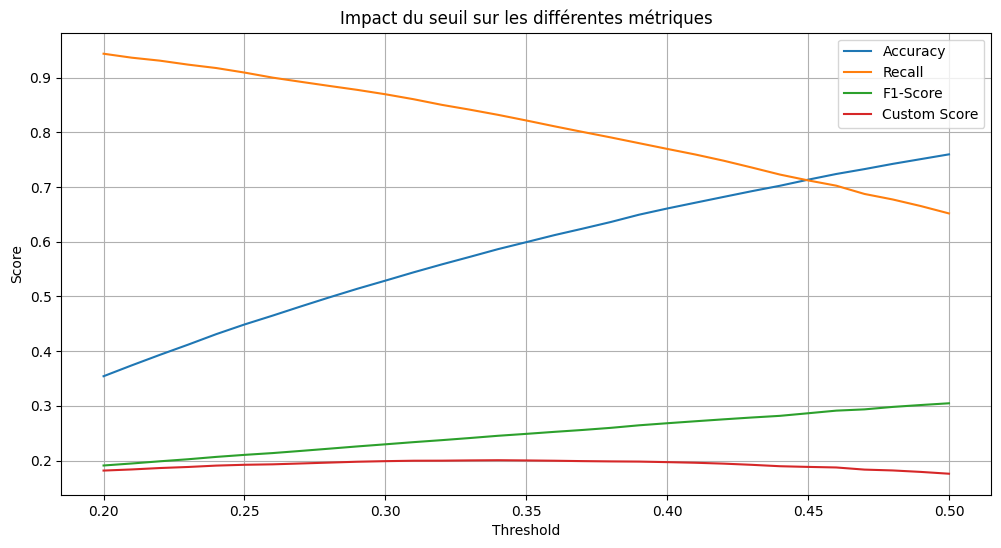

In [56]:
# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(results_df['threshold'], results_df['accuracy'], label='Accuracy')
plt.plot(results_df['threshold'], results_df['recall'], label='Recall')
plt.plot(results_df['threshold'], results_df['f1_score'], label='F1-Score')
plt.plot(results_df['threshold'], results_df['custom_credit_score'], label='Custom Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Impact du seuil sur les différentes métriques')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Afficher les meilleurs seuils
print("\nMeilleurs seuils par métrique:")
for metric, threshold in best_thresholds.items():
    print(f"{metric}: {threshold:.3f}")


Meilleurs seuils par métrique:
accuracy: 0.500
recall: 0.200
f1_score: 0.500
custom_credit_score: 0.340


# GRID SEARCH POUR LE MEILLEUR MODELE

In [58]:
# Configuration des paramètres
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [ 0.1, 0.2], 
    'num_leaves': [31, 62],
    'max_depth': [5, 7]
}

param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
results = []

for params in param_combinations:
    print(f"\nTest des paramètres: {params}")
    
    fold_scores = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in skf.split(X_train_scaled, y_train):
        # Utiliser .iloc pour les DataFrames
        X_fold_train = X_train_scaled.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train_scaled.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Créer et entraîner le modèle
        model = lgb.LGBMClassifier(
            **params,
            objective='binary',
            scale_pos_weight=10
        )
        
        model.fit(X_fold_train, y_fold_train)
        
        # Prédictions
        y_pred_proba = model.predict_proba(X_fold_val)
        y_pred = (y_pred_proba[:, 1] >= 0.34).astype(int)
        
        # Score
        score = custom_credit_score(y_fold_val, y_pred, fn_weight=10, fp_weight=1)
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    
    results.append({
        'params': params,
        'mean_score': mean_score,
        'std_score': std_score
    })
    
    print(f"Score moyen: {mean_score:.4f} (±{std_score:.4f})")

# Meilleurs paramètres
best_result = max(results, key=lambda x: x['mean_score'])


Test des paramètres: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 5}
[LightGBM] [Info] Number of positive: 15888, number of negative: 180916
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.558498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99256
[LightGBM] [Info] Number of data points in the train set: 196804, number of used features: 729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432469
[LightGBM] [Info] Start training from score -2.432469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [59]:
print("\nMeilleurs paramètres trouvés:")
print(best_result['params'])
print(f"\nMeilleur score: {best_result['mean_score']:.4f} (±{best_result['std_score']:.4f})")


Meilleurs paramètres trouvés:
{'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 7}

Meilleur score: 0.1993 (±0.0023)


In [60]:
# Résultats triés
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('mean_score', ascending=False)
print("\nTous les résultats triés par score:")
print(results_df)


Tous les résultats triés par score:
                                               params  mean_score  std_score
1   {'n_estimators': 100, 'learning_rate': 0.1, 'n...    0.199281   0.002321
9   {'n_estimators': 200, 'learning_rate': 0.1, 'n...    0.199039   0.001641
10  {'n_estimators': 200, 'learning_rate': 0.1, 'n...    0.198593   0.001677
8   {'n_estimators': 200, 'learning_rate': 0.1, 'n...    0.198306   0.002085
3   {'n_estimators': 100, 'learning_rate': 0.1, 'n...    0.197914   0.001024
0   {'n_estimators': 100, 'learning_rate': 0.1, 'n...    0.197387   0.001773
2   {'n_estimators': 100, 'learning_rate': 0.1, 'n...    0.196693   0.001827
4   {'n_estimators': 100, 'learning_rate': 0.2, 'n...    0.194739   0.002043
5   {'n_estimators': 100, 'learning_rate': 0.2, 'n...    0.194505   0.001176
6   {'n_estimators': 100, 'learning_rate': 0.2, 'n...    0.194474   0.001250
11  {'n_estimators': 200, 'learning_rate': 0.1, 'n...    0.192955   0.001834
14  {'n_estimators': 200, 'learning_rat

# FEATURES IMORTANCE DU MEILLEUR MODELE

In [61]:
# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

# Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=True).tail(20)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.325486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


<Figure size 1200x800 with 0 Axes>

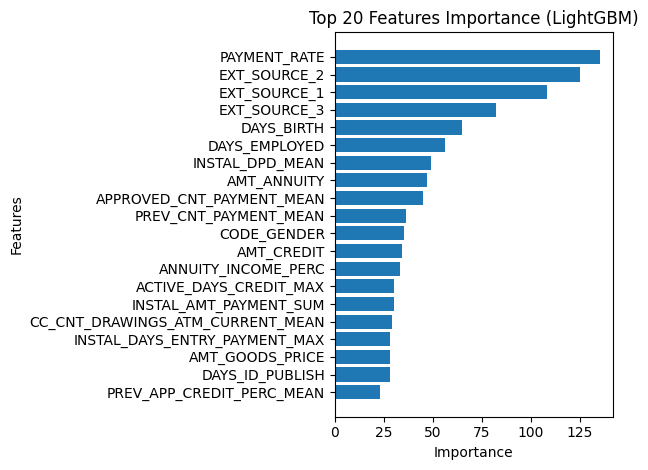

In [62]:
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Top 20 Features Importance (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [63]:
# Afficher aussi les valeurs numériques
print("\nTop 20 features les plus importantes:")
print(feature_importance.sort_values('importance', ascending=False))


Top 20 features les plus importantes:
                              feature  importance
244                      PAYMENT_RATE         135
31                       EXT_SOURCE_2         125
30                       EXT_SOURCE_1         108
32                       EXT_SOURCE_3          82
9                          DAYS_BIRTH          65
10                      DAYS_EMPLOYED          56
630                   INSTAL_DPD_MEAN          49
6                         AMT_ANNUITY          47
578         APPROVED_CNT_PAYMENT_MEAN          45
389             PREV_CNT_PAYMENT_MEAN          36
0                         CODE_GENDER          35
5                          AMT_CREDIT          34
243               ANNUITY_INCOME_PERC          33
649            INSTAL_AMT_PAYMENT_SUM          30
308            ACTIVE_DAYS_CREDIT_MAX          30
721  CC_CNT_DRAWINGS_ATM_CURRENT_MEAN          29
7                     AMT_GOODS_PRICE          28
650     INSTAL_DAYS_ENTRY_PAYMENT_MAX          28
12         

# SHAP VALUE DU MEILLEUR MODELE

In [64]:
# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

best_model.fit(X_train_scaled, y_train)

# Créer l'explainer SHAP
explainer = shap.TreeExplainer(best_model)

# Calculer les valeurs SHAP (avec un échantillon pour accélérer)
# Utiliser un échantillon plus petit si nécessaire
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled.iloc[sample_indices]

# Nouvelle méthode pour obtenir les SHAP values
shap_values = explainer(X_sample)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.371633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


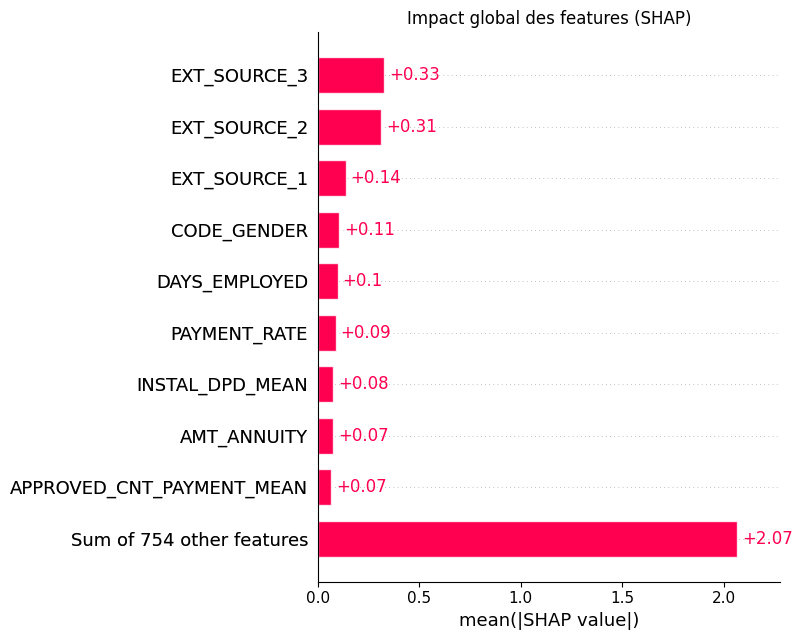

In [65]:
# Plot résumé des SHAP values (nouveau format)
plt.figure(figsize=(10, 8))
shap.plots.bar(shap_values, show=False)
plt.title("Impact global des features (SHAP)")
plt.tight_layout()
plt.show()

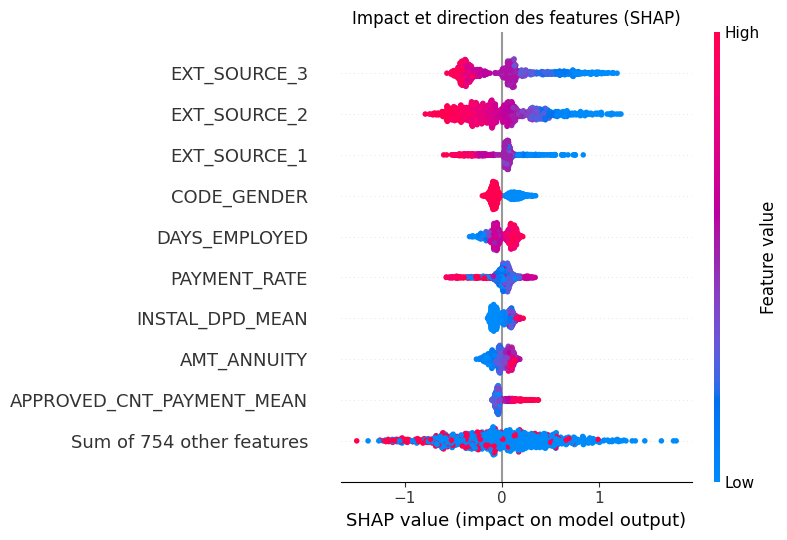

In [66]:
# Plot détaillé
plt.figure(figsize=(10, 8))
shap.plots.beeswarm(shap_values, show=False)
plt.title("Impact et direction des features (SHAP)")
plt.tight_layout()
plt.show()

# SAUVEGARDE DU MODELE

In [67]:
# Créer le dossier models s'il n'existe pas
if not os.path.exists('models'):
    os.makedirs('models')

# Créer et entraîner le meilleur modèle
best_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

# Entraîner le modèle sur l'ensemble du jeu d'entraînement
best_model.fit(X_train_scaled, y_train)

# Sauvegarder le modèle et le scaler
joblib.dump(best_model, 'models/lgbm_model.joblib')
joblib.dump(scaler, 'models/scaler.joblib')

print("Modèle et scaler sauvegardés avec succès dans le dossier 'models'")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.384390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99361
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 730
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884
Modèle et scaler sauvegardés avec succès dans le dossier 'models'


# REDUCTION DES FEATURES

In [68]:
# Obtenir l'importance des features
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Définir une série de seuils à tester
feature_counts = [10, 20, 30, 40, 50, 75, 100, 150, 200, 300, 400, 500, len(X_train_scaled.columns)]
results = []

# Pour chaque nombre de features
for n_features in feature_counts:
    # Sélectionner les top n features
    top_features = feature_importance.head(n_features)['feature'].tolist()
    X_train_subset = X_train_scaled[top_features]
    X_test_subset = X_test_scaled[top_features]
    
    # Entraîner un modèle sur ce sous-ensemble
    subset_model = lgb.LGBMClassifier(
        n_estimators=best_result['params']['n_estimators'],
        learning_rate=best_result['params']['learning_rate'],
        num_leaves=best_result['params']['num_leaves'],
        max_depth=best_result['params']['max_depth'],
        class_weight={0:1, 1:10},
        random_state=42
    )
    subset_model.fit(X_train_subset, y_train)
    
    # Évaluer les performances
    y_pred_proba = subset_model.predict_proba(X_test_subset)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Calculer le custom score avec le seuil optimal (0.34)
    y_pred = (y_pred_proba >= 0.34).astype(int)
    custom_score_value = custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1)
    
    results.append({
        'n_features': n_features,
        'auc': auc,
        'custom_score': custom_score_value
    })
    print(f"Nombre de features: {n_features}, AUC: {auc:.4f}, Custom Score: {custom_score_value:.4f}")

# Convertir en DataFrame
results_df = pd.DataFrame(results)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884
Nombre de features: 10, AUC: 0.7628, Custom Score: 0.1906
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4809
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[Lig

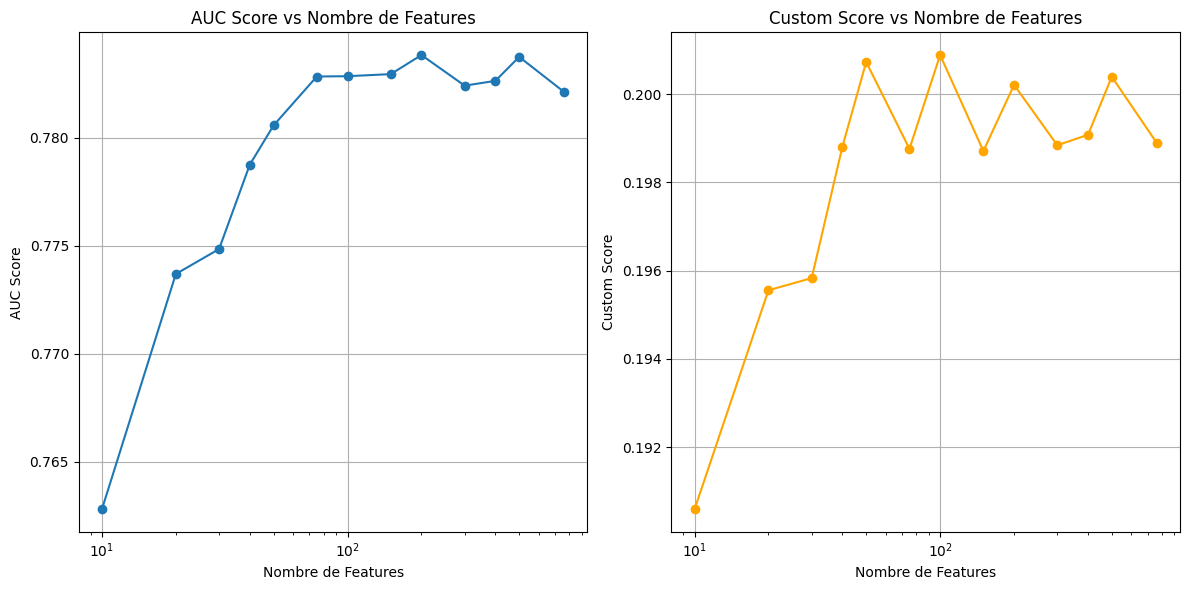

In [69]:
# Visualiser les résultats
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df['n_features'], results_df['auc'], marker='o')
plt.title('AUC Score vs Nombre de Features')
plt.xlabel('Nombre de Features')
plt.ylabel('AUC Score')
plt.xscale('log')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(results_df['n_features'], results_df['custom_score'], marker='o', color='orange')
plt.title('Custom Score vs Nombre de Features')
plt.xlabel('Nombre de Features')
plt.ylabel('Custom Score')
plt.xscale('log')
plt.grid(True)

plt.tight_layout()
plt.show()

In [70]:
# Trouver le nombre optimal de features
optimal_n_features_auc = results_df.loc[results_df['auc'].idxmax(), 'n_features']
optimal_n_features_custom = results_df.loc[results_df['custom_score'].idxmax(), 'n_features']

print(f"Nombre optimal de features basé sur l'AUC: {optimal_n_features_auc}")
print(f"Nombre optimal de features basé sur le Custom Score: {optimal_n_features_custom}")

Nombre optimal de features basé sur l'AUC: 200
Nombre optimal de features basé sur le Custom Score: 100


# GARDER LES 50 FEATURES LES PLUS IMPORTANTES

In [71]:
# Obtenir les 50 features les plus importantes
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
top_50_features = feature_importance.head(50)['feature'].tolist()

# Créer des sous-ensembles de données avec ces 50 features
X_train_reduced = X_train_scaled[top_50_features]
X_test_reduced = X_test_scaled[top_50_features]

# Entraîner le modèle final avec ces features
final_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

params = {

    'n_estimators' : best_result['params']['n_estimators'],
    'learning_rate' : best_result['params']['learning_rate'],
    'num_leaves' : best_result['params']['num_leaves'],
    'max_depth' : best_result['params']['max_depth'],
    'class_weight' : {0:1, 1:10},
    'random_state' : 42

}

train_and_evaluate_model(final_model,X_train_reduced,X_test_reduced,y_train,y_test,params,0.34)


final_model.fit(X_train_reduced, y_train)

# Évaluer les performances
y_pred_proba = final_model.predict_proba(X_test_reduced)[:, 1]
y_pred = (y_pred_proba >= 0.34).astype(int)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11196
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/25 15:17:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.5739
recall: 0.8417
f1_score: 0.2418
auc_score: 0.7806
custom_credit_score: 0.2007
🏃 View run LGBMClassifier_50_features at: http://localhost:5000/#/experiments/713072862009697132/runs/daab73aad22b4b75b7287b91fa7b76a3
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11196
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


In [72]:
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de confusion:
[[31116 25421]
 [  786  4179]]


In [73]:
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.98      0.55      0.70     56537
         1.0       0.14      0.84      0.24      4965

    accuracy                           0.57     61502
   macro avg       0.56      0.70      0.47     61502
weighted avg       0.91      0.57      0.67     61502



In [74]:
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Custom Score: {custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1):.4f}")

AUC Score: 0.7806
Custom Score: 0.2007


In [75]:
if not os.path.exists('models'):
    os.makedirs('models')

# Sauvegarder le modèle
joblib.dump(final_model, 'models/lgbm_reduced_model.joblib')

# Sauvegarder la liste des features
with open('models/top_50_features.pkl', 'wb') as f:
    pickle.dump(top_50_features, f)

# Sauvegarder également le scaler
joblib.dump(scaler, 'models/scaler.joblib')

print("\nModèle réduit et liste des features sauvegardés avec succès!")
print("Modèle: models/lgbm_reduced_model.joblib")
print("Features: models/top_50_features.pkl")
print("Scaler: models/scaler.joblib")


Modèle réduit et liste des features sauvegardés avec succès!
Modèle: models/lgbm_reduced_model.joblib
Features: models/top_50_features.pkl
Scaler: models/scaler.joblib


# RECHERCHE DES FEATURES CORRELEES

In [76]:
# 1. Calculer la matrice de corrélation pour les 50 top features
correlation_matrix = X_train_reduced.corr().abs()

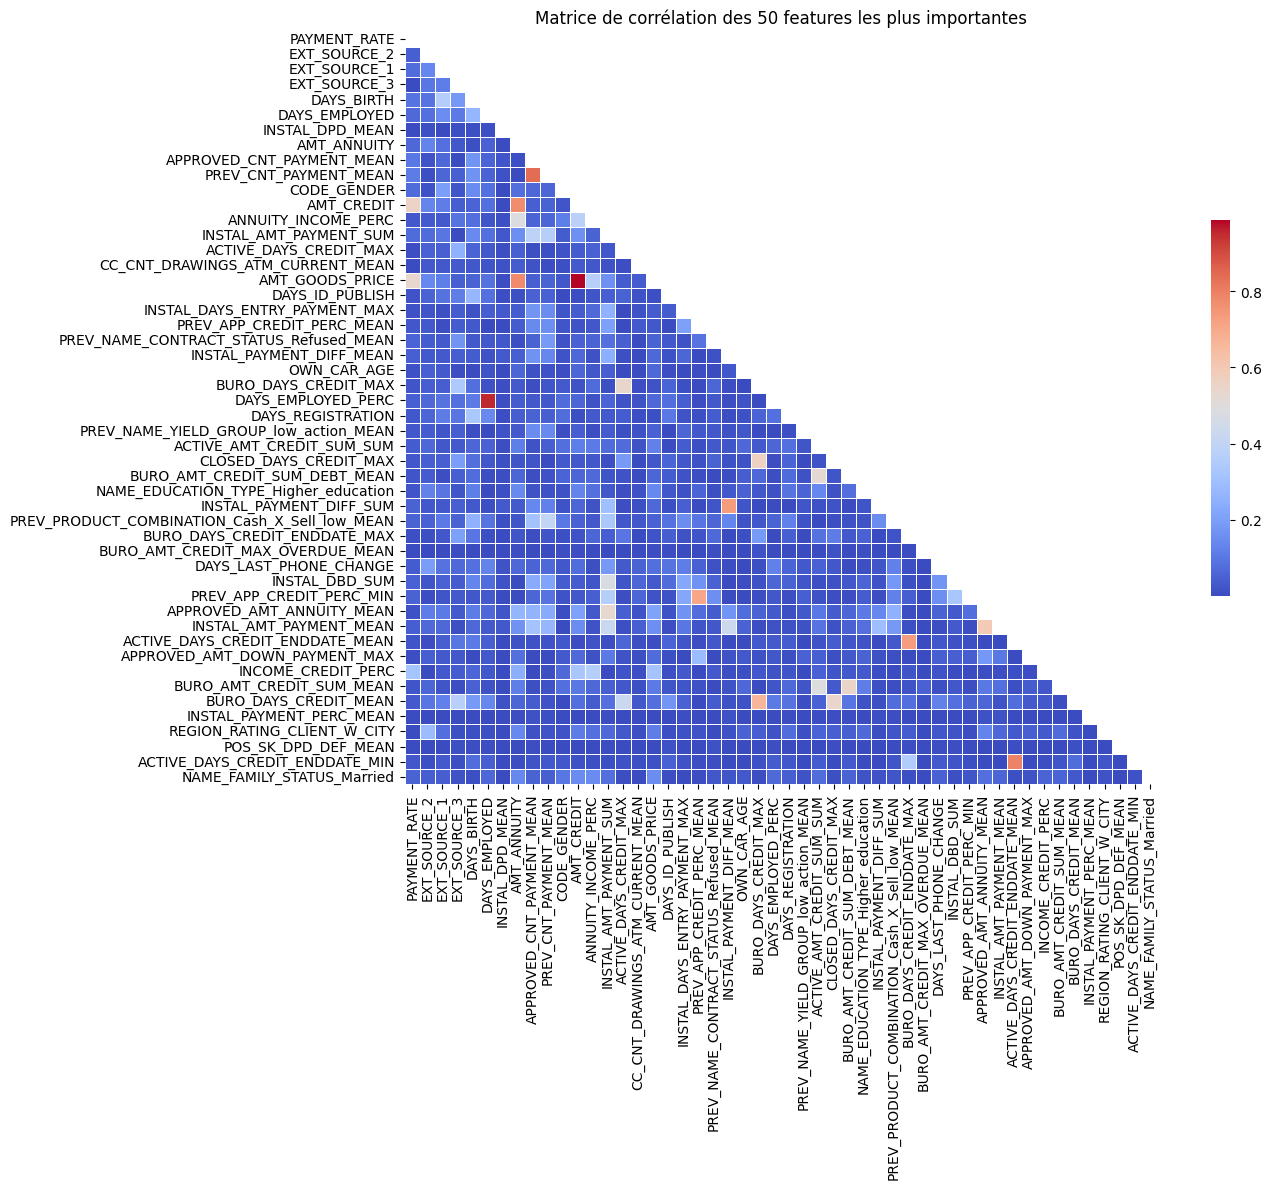

In [77]:
# 2. Visualiser la matrice de corrélation avec une heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, 
            mask=mask, 
            cmap='coolwarm', 
            annot=False, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5})
plt.title('Matrice de corrélation des 50 features les plus importantes')
plt.tight_layout()
plt.show()

In [78]:
# 3. Identifier les paires de features fortement corrélées (seuil de 0.8 par exemple)
threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] >= threshold:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

# 4. Afficher les paires de features fortement corrélées
if high_corr_pairs:
    print(f"Paires de features avec une corrélation ≥ {threshold}:")
    for feature1, feature2, corr in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"{feature1} et {feature2}: {corr:.3f}")
else:
    print(f"Aucune paire de features avec une corrélation ≥ {threshold} n'a été trouvée.")

# 5. Option: Supprimer une feature de chaque paire fortement corrélée
features_to_remove = []
for pair in high_corr_pairs:
    feature1, feature2, _ = pair
    
    # On choisit laquelle des deux features supprimer (celle de moindre importance)
    idx1 = feature_importance[feature_importance['feature'] == feature1].index[0]
    idx2 = feature_importance[feature_importance['feature'] == feature2].index[0]
    
    # On conserve celle qui a le rang d'importance le plus élevé (index le plus petit dans feature_importance)
    if idx1 < idx2:
        features_to_remove.append(feature2)
    else:
        features_to_remove.append(feature1)

# Supprimer les doublons
features_to_remove = list(set(features_to_remove))

if features_to_remove:
    print(f"\nFeatures qui pourraient être supprimées: {len(features_to_remove)}")
    for f in features_to_remove:
        print(f"- {f}")
    
    # Créer un nouveau jeu de données sans les features fortement corrélées
    reduced_features = [f for f in top_50_features if f not in features_to_remove]
    print(f"\nNombre de features après suppression des corrélations: {len(reduced_features)}")
else:
    print("Aucune feature à supprimer.")

Paires de features avec une corrélation ≥ 0.8:
AMT_CREDIT et AMT_GOODS_PRICE: 0.987
DAYS_EMPLOYED et DAYS_EMPLOYED_PERC: 0.955
APPROVED_CNT_PAYMENT_MEAN et PREV_CNT_PAYMENT_MEAN: 0.837

Features qui pourraient être supprimées: 3
- APPROVED_CNT_PAYMENT_MEAN
- AMT_GOODS_PRICE
- DAYS_EMPLOYED_PERC

Nombre de features après suppression des corrélations: 47


# RETRAIT DES FEAUTRES CORRELEES ET SCORE

In [79]:
# Créer la liste des features optimisées en supprimant les features corrélées
optimized_features = [f for f in top_50_features if f not in ['APPROVED_CNT_PAYMENT_MEAN', 'AMT_GOODS_PRICE', 'DAYS_EMPLOYED_PERC']]

# Vérifier que nous avons bien 47 features
print(f"Nombre de features optimisées: {len(optimized_features)}")

# Créer des sous-ensembles de données avec ces features optimisées
X_train_optimized = X_train_scaled[optimized_features]
X_test_optimized = X_test_scaled[optimized_features]

# Entraîner le modèle final avec ces features optimisées
final_optimized_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

params = {

    'n_estimators' : best_result['params']['n_estimators'],
    'learning_rate' : best_result['params']['learning_rate'],
    'num_leaves' : best_result['params']['num_leaves'],
    'max_depth' : best_result['params']['max_depth'],
    'class_weight' : {0:1, 1:10},
    'random_state' : 42

}

train_and_evaluate_model(final_optimized_model,X_train_optimized,X_test_optimized,y_train,y_test,params,0.34)


final_optimized_model.fit(X_train_optimized, y_train)

# Évaluer les performances
y_pred_proba = final_optimized_model.predict_proba(X_test_optimized)[:, 1]
y_pred = (y_pred_proba >= 0.34).astype(int)


Nombre de features optimisées: 47
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10450
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/25 15:17:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.5737
recall: 0.8375
f1_score: 0.2408
auc_score: 0.7796
custom_credit_score: 0.1990
🏃 View run LGBMClassifier_47_features at: http://localhost:5000/#/experiments/713072862009697132/runs/867e363f35084a8aadb5415cb2a744a7
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10450
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


In [80]:
# Calculer les métriques
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de confusion:
[[31127 25410]
 [  807  4158]]


In [81]:
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70     56537
         1.0       0.14      0.84      0.24      4965

    accuracy                           0.57     61502
   macro avg       0.56      0.69      0.47     61502
weighted avg       0.91      0.57      0.67     61502



In [82]:
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Custom Score: {custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1):.4f}")

AUC Score: 0.7796
Custom Score: 0.1990


In [83]:
# Sauvegarder le modèle et la liste des features
joblib.dump(final_optimized_model, 'models/lgbm_optimized_model.joblib')
with open('models/optimized_features.pkl', 'wb') as f:
    pickle.dump(optimized_features, f)

print("\nModèle optimisé et liste des features sauvegardés avec succès!")
print("Modèle: models/lgbm_optimized_model.joblib")
print("Features: models/optimized_features.pkl")


Modèle optimisé et liste des features sauvegardés avec succès!
Modèle: models/lgbm_optimized_model.joblib
Features: models/optimized_features.pkl


# RECUPERATION DU DATAFRAME AVEC SEULEMENT LES BONNES COLONNES

In [84]:
DF_reduced = DF_final[['SK_ID_CURR','TARGET']+optimized_features]

In [85]:
DF_reduced = DF_reduced.set_index('SK_ID_CURR')

In [86]:
DF_reduced

,TARGET,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_1,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,INSTAL_DPD_MEAN,AMT_ANNUITY,PREV_CNT_PAYMENT_MEAN,...,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,APPROVED_AMT_DOWN_PAYMENT_MAX,INCOME_CREDIT_PERC,BURO_AMT_CREDIT_SUM_MEAN,BURO_DAYS_CREDIT_MEAN,INSTAL_PAYMENT_PERC_MEAN,REGION_RATING_CLIENT_W_CITY,POS_SK_DPD_DEF_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,NAME_FAMILY_STATUS_Married
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0.060749,0.262949,0.083037,0.139376,-9461,-637.0,0.000000,24700.5,24.000000,...,780.0,0.0,0.498036,1.081319e+05,-874.000000,1.000000,2,0.0,780.0,False
100003,0.0,0.027598,0.622246,0.311267,NaN,-16765,-1188.0,0.000000,35698.5,10.000000,...,1216.0,6885.0,0.208736,2.543501e+05,-1400.750000,1.000000,1,0.0,1216.0,True
100004,0.0,0.050000,0.555912,NaN,0.729567,-19046,-225.0,0.000000,6750.0,4.000000,...,NaN,4860.0,0.500000,9.451890e+04,-867.000000,1.000000,2,0.0,NaN,False
100006,0.0,0.094941,0.650442,NaN,NaN,-19005,-3039.0,0.000000,29686.5,23.000000,...,NaN,66987.0,0.431748,NaN,NaN,1.000000,2,0.0,NaN,False
100007,0.0,0.042623,0.322738,NaN,NaN,-19932,-3038.0,0.954545,21865.5,20.666667,...,NaN,3676.5,0.236842,1.462500e+05,-1149.000000,0.954545,2,0.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,NaN,0.042354,0.648575,NaN,0.643026,-19970,-5169.0,0.000000,17473.5,24.000000,...,644.0,NaN,0.294503,2.237598e+05,-727.200000,1.000000,3,0.0,495.0,False
456222,NaN,0.051267,0.684596,NaN,NaN,-11186,-1149.0,0.520548,31909.5,17.500000,...,NaN,3600.0,0.253047,NaN,NaN,0.958904,2,0.0,NaN,True
456223,NaN,0.105414,0.632770,0.733503,0.283712,-15922,-3037.0,0.000000,33205.5,11.000000,...,NaN,17086.5,0.642857,4.312619e+05,-539.000000,1.000000,2,0.0,NaN,True


In [87]:
DF_train_reduced = DF_reduced.loc[~DF_reduced['TARGET'].isna()]

In [88]:
DF_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 48 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   TARGET                                         307507 non-null  float64
 1   PAYMENT_RATE                                   307495 non-null  float64
 2   EXT_SOURCE_2                                   306847 non-null  float64
 3   EXT_SOURCE_1                                   134131 non-null  float64
 4   EXT_SOURCE_3                                   246542 non-null  float64
 5   DAYS_BIRTH                                     307507 non-null  int64  
 6   DAYS_EMPLOYED                                  252133 non-null  float64
 7   INSTAL_DPD_MEAN                                291639 non-null  float64
 8   AMT_ANNUITY                                    307495 non-null  float64
 9   PREV_CNT_PAYMENT_MEAN                

In [89]:
DF_test_reduced = DF_reduced.loc[DF_reduced['TARGET'].isna()]

In [90]:
DF_test_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48744 entries, 100001 to 456250
Data columns (total 48 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   TARGET                                         0 non-null      float64
 1   PAYMENT_RATE                                   48720 non-null  float64
 2   EXT_SOURCE_2                                   48736 non-null  float64
 3   EXT_SOURCE_1                                   28212 non-null  float64
 4   EXT_SOURCE_3                                   40076 non-null  float64
 5   DAYS_BIRTH                                     48744 non-null  int64  
 6   DAYS_EMPLOYED                                  39470 non-null  float64
 7   INSTAL_DPD_MEAN                                47944 non-null  float64
 8   AMT_ANNUITY                                    48720 non-null  float64
 9   PREV_CNT_PAYMENT_MEAN                          47

# CREATION DU DATAFRAME A IMPUTER

In [143]:
X_to_impute = DF_train_reduced.drop(['TARGET'] , axis = 1)
y = DF_train_reduced['TARGET']

## REMPLACEMENT DES VALEURS INFINIES

In [144]:
# 1. D'abord vérifions les types de données
print("Types de données dans X :")


# 2. Sélectionnons uniquement les colonnes numériques
numeric_columns = X_to_impute.select_dtypes(include=['float64', 'int64']).columns

# 3. Maintenant vérifions les infinis dans les colonnes numériques
print("\nColonnes avec des infinis :")
inf_columns = []
for col in numeric_columns:
    if (X_to_impute[col] == np.inf).any() or (X_to_impute[col] == -np.inf).any():
        inf_columns.append(col)
print(inf_columns)

# 4. Nettoyons les données
for col in numeric_columns:
    # Remplacer les infinis par NaN
    X_to_impute[col] = X_to_impute[col].replace([np.inf, -np.inf], np.nan)

for col in X_to_impute.columns :

    if X_to_impute[col].dtype == 'bool':
        X_to_impute[col] = X_to_impute[col].astype(int)

print(X_to_impute.dtypes)
    

Types de données dans X :

Colonnes avec des infinis :
['PREV_APP_CREDIT_PERC_MEAN', 'INSTAL_PAYMENT_PERC_MEAN']
PAYMENT_RATE                                     float64
EXT_SOURCE_2                                     float64
EXT_SOURCE_1                                     float64
EXT_SOURCE_3                                     float64
DAYS_BIRTH                                         int64
DAYS_EMPLOYED                                    float64
INSTAL_DPD_MEAN                                  float64
AMT_ANNUITY                                      float64
PREV_CNT_PAYMENT_MEAN                            float64
CODE_GENDER                                        int64
AMT_CREDIT                                       float64
ANNUITY_INCOME_PERC                              float64
INSTAL_AMT_PAYMENT_SUM                           float64
ACTIVE_DAYS_CREDIT_MAX                           float64
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN                 float64
DAYS_ID_PUBLISH                 

# IMPUTATION KNN AVEC FAISS

In [145]:
# Code à remplacer dans votre notebook

# Importer la fonction simple_knn_imputer
from sklearn.impute import KNNImputer
from tqdm import tqdm
import numpy as np
import pandas as pd

def simple_knn_imputer(X, n_neighbors=5):
    """
    Impute les valeurs manquantes en utilisant l'algorithme KNN de scikit-learn
    
    Args:
        X: DataFrame avec valeurs manquantes
        n_neighbors: Nombre de voisins à utiliser
        
    Returns:
        DataFrame avec valeurs imputées
    """
    print(f"Démarrage de l'imputation KNN avec {n_neighbors} voisins...")
    
    # Vérifier s'il y a des valeurs manquantes
    if not X.isna().any().any():
        print("Aucune valeur manquante à imputer.")
        return X.copy()
    
    # Initialiser l'imputer KNN de scikit-learn
    imputer = KNNImputer(n_neighbors=n_neighbors, weights="uniform")
    
    # Imputer toutes les valeurs manquantes en une seule opération
    X_imputed_array = imputer.fit_transform(X)
    
    # Convertir le résultat en DataFrame avec les mêmes index et colonnes
    X_imputed = pd.DataFrame(X_imputed_array, index=X.index, columns=X.columns)
    
    print("Imputation terminée!")
    
    return X_imputed

# 1. Appliquer le scaling comme vous l'avez fait
scaler = StandardScaler()
mask_non_nan = ~X_to_impute.isna()
X_scaled = X_to_impute.copy()

for col in X_to_impute.columns:
    valid_values = X_to_impute.loc[mask_non_nan[col], col].values.reshape(-1, 1)
    if len(valid_values) > 0:
        scaler.fit(valid_values)
        temp_values = X_to_impute[col].fillna(0).values.reshape(-1, 1)
        scaled_values = scaler.transform(temp_values).flatten()
        X_scaled[col] = scaled_values
        X_scaled.loc[~mask_non_nan[col], col] = np.nan

# 2. Appliquer l'imputation KNN simple à la place de FAISS
print("Démarrage de l'imputation KNN simple...")
X_knn_imputed = simple_knn_imputer(X_scaled, n_neighbors=5)  
print("Imputation terminée!")

# 3. Reconstituer le DataFrame complet avec TARGET
knn_df_complete = X_knn_imputed.copy()
knn_df_complete['TARGET'] = y

# Sauvegarder le résultat
knn_df_complete.to_csv('data_knn_imputed_scaled.csv')

# Pour continuer avec le split train/test:
X_train, X_test, y_train, y_test = train_test_split(
    X_knn_imputed, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Puis entraîner le modèle comme avant
KNN_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

params = {
    'n_estimators': best_result['params']['n_estimators'],
    'learning_rate': best_result['params']['learning_rate'],
    'num_leaves': best_result['params']['num_leaves'],
    'max_depth': best_result['params']['max_depth'],
    'class_weight': {0:1, 1:10},
    'random_state': 42
}

train_and_evaluate_model(KNN_model, X_train, X_test, y_train, y_test, params, 0.34, name='LGBM_KNN_simple_impute')

Démarrage de l'imputation KNN simple...
Démarrage de l'imputation KNN avec 5 voisins...
Imputation terminée!
Imputation terminée!
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10862
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/26 01:19:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.5664
recall: 0.8350
f1_score: 0.2372
auc_score: 0.7744
custom_credit_score: 0.1959
🏃 View run LGBM_KNN_simple_impute at: http://localhost:5000/#/experiments/713072862009697132/runs/a57b343fa4c14b24a6b018da26c147e0
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132


(LGBMClassifier(class_weight={0: 1, 1: 10}, max_depth=7, random_state=42),
 {'accuracy': 0.5664206042079932,
  'recall': 0.8350453172205438,
  'f1_score': 0.23719892442359403,
  'auc_score': np.float64(0.7744026784160329),
  'custom_credit_score': np.float64(0.19589406789671385)},
 'a57b343fa4c14b24a6b018da26c147e0')

In [146]:
KNN_model.fit(X_train, y_train)

# Évaluer les performances
y_pred_proba = KNN_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.34).astype(int)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10862
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


In [147]:
# Calculer les métriques
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de confusion:
[[30690 25847]
 [  819  4146]]


In [148]:
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.97      0.54      0.70     56537
         1.0       0.14      0.84      0.24      4965

    accuracy                           0.57     61502
   macro avg       0.56      0.69      0.47     61502
weighted avg       0.91      0.57      0.66     61502



In [149]:
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Custom Score: {custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1):.4f}")

AUC Score: 0.7744
Custom Score: 0.1959


In [150]:
# Sauvegarder le modèle et la liste des features
joblib.dump(KNN_model, 'models/KNN_model.joblib')


print("\nModèle KNN sauvegardé avec succès!")
print("Modèle: models/KNN_model.joblib")


Modèle KNN sauvegardé avec succès!
Modèle: models/KNN_model.joblib


# IMPUTATION PAR 0

In [151]:
X_impute_0 = X_to_impute.copy() 

In [152]:
X_impute_0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307507 entries, 100002 to 456255
Data columns (total 47 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   PAYMENT_RATE                                   307495 non-null  float64
 1   EXT_SOURCE_2                                   306847 non-null  float64
 2   EXT_SOURCE_1                                   134131 non-null  float64
 3   EXT_SOURCE_3                                   246542 non-null  float64
 4   DAYS_BIRTH                                     307507 non-null  int64  
 5   DAYS_EMPLOYED                                  252133 non-null  float64
 6   INSTAL_DPD_MEAN                                291639 non-null  float64
 7   AMT_ANNUITY                                    307495 non-null  float64
 8   PREV_CNT_PAYMENT_MEAN                          290638 non-null  float64
 9   CODE_GENDER                          

In [153]:
for col in X_impute_0.columns:
    if X_impute_0[col].dtype != 'bool' : X_impute_0.loc[X_impute_0[col].isna(),col]=0
    else:
        X_impute_0.loc[X_impute_0[col].isna(),col]=X_impute_0[col].mode()[0]


In [154]:
X_impute_0.to_csv('DF_impute_0.csv', index=True)

In [155]:
X_train, X_test, y_train, y_test = train_test_split(
    X_impute_0, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [156]:
# Entraîner le modèle final avec ces features optimisées
O_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

params = {

    'n_estimators' : best_result['params']['n_estimators'],
    'learning_rate' : best_result['params']['learning_rate'],
    'num_leaves' : best_result['params']['num_leaves'],
    'max_depth' : best_result['params']['max_depth'],
    'class_weight' : {0:1, 1:10},
    'random_state' : 42

}

train_and_evaluate_model(O_model,X_train,X_test,y_train,y_test,params,0.34,name = 'LGBM_0_impute')


O_model.fit(X_train, y_train)

# Évaluer les performances
y_pred_proba = O_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.34).astype(int)

[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/26 01:19:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.5712
recall: 0.8393
f1_score: 0.2401
auc_score: 0.7792
custom_credit_score: 0.1989
🏃 View run LGBM_0_impute at: http://localhost:5000/#/experiments/713072862009697132/runs/177f3b37d3b5492c936b741fc58f0e9d
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10455
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


In [157]:
# Calculer les métriques
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de confusion:
[[30960 25577]
 [  798  4167]]


In [158]:
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.97      0.55      0.70     56537
         1.0       0.14      0.84      0.24      4965

    accuracy                           0.57     61502
   macro avg       0.56      0.69      0.47     61502
weighted avg       0.91      0.57      0.66     61502



In [159]:
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Custom Score: {custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1):.4f}")

AUC Score: 0.7792
Custom Score: 0.1989


In [160]:
# Sauvegarder le modèle et la liste des features
joblib.dump(O_model, 'models/0_model.joblib')


print("\nModèle 0_impute sauvegardé avec succès!")
print("Modèle: models/0_model.joblib")


Modèle 0_impute sauvegardé avec succès!
Modèle: models/0_model.joblib


# IMPUTATION PAR MEDIANE

In [161]:
X_impute_median = X_to_impute.copy() 

In [162]:
for col in X_impute_median.columns:
    if X_impute_median[col].dtype != 'bool' : X_impute_median.loc[X_impute_median[col].isna(),col]=X_impute_median[col].median()
    else:
        X_impute_median.loc[X_impute_median[col].isna(),col]=X_impute_median[col].mode()[0]


In [163]:
X_impute_median.to_csv('DF_median_impute.csv', index=True)

In [164]:
X_train, X_test, y_train, y_test = train_test_split(
    X_impute_median, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [165]:
# Entraîner le modèle final avec ces features optimisées
median_model = lgb.LGBMClassifier(
    n_estimators=best_result['params']['n_estimators'],
    learning_rate=best_result['params']['learning_rate'],
    num_leaves=best_result['params']['num_leaves'],
    max_depth=best_result['params']['max_depth'],
    class_weight={0:1, 1:10},
    random_state=42
)

params = {

    'n_estimators' : best_result['params']['n_estimators'],
    'learning_rate' : best_result['params']['learning_rate'],
    'num_leaves' : best_result['params']['num_leaves'],
    'max_depth' : best_result['params']['max_depth'],
    'class_weight' : {0:1, 1:10},
    'random_state' : 42

}

train_and_evaluate_model(median_model,X_train,X_test,y_train,y_test,params,0.34,name = 'LGBM_median_impute')


median_model.fit(X_train, y_train)

# Évaluer les performances
y_pred_proba = median_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.34).astype(int)


[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10456
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


2025/02/26 01:20:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Résultats pour LGBMClassifier:
accuracy: 0.5727
recall: 0.8447
f1_score: 0.2419
auc_score: 0.7790
custom_credit_score: 0.2016
🏃 View run LGBM_median_impute at: http://localhost:5000/#/experiments/713072862009697132/runs/3581603eb113444a81d045b50b3f1cdd
🧪 View experiment at: http://localhost:5000/#/experiments/713072862009697132
[LightGBM] [Info] Number of positive: 19860, number of negative: 226145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10456
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467575 -> initscore=-0.129884
[LightGBM] [Info] Start training from score -0.129884


In [166]:
# Calculer les métriques
print("Matrice de confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de confusion:
[[31026 25511]
 [  771  4194]]


In [167]:
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))


Rapport de classification:
              precision    recall  f1-score   support

         0.0       0.98      0.55      0.70     56537
         1.0       0.14      0.84      0.24      4965

    accuracy                           0.57     61502
   macro avg       0.56      0.70      0.47     61502
weighted avg       0.91      0.57      0.67     61502



In [168]:
print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Custom Score: {custom_credit_score(y_test, y_pred, fn_weight=10, fp_weight=1):.4f}")

AUC Score: 0.7790
Custom Score: 0.2016


In [169]:
# Sauvegarder le modèle et la liste des features
joblib.dump(median_model, 'models/median_model.joblib')


print("\nModèle median_impute sauvegardé avec succès!")
print("Modèle: models/median_model.joblib")


Modèle median_impute sauvegardé avec succès!
Modèle: models/median_model.joblib


In [170]:
# Correction: utiliser y_pred_proba_total pour calculer y_pred_total
y_pred_proba_total = median_model.predict_proba(X_impute_median)[:, 1]
y_pred_total = (y_pred_proba_total >= 0.34).astype(int)

# Créer un DataFrame pour l'analyse
analysis_df = X_impute_median.copy()
analysis_df['TARGET_REAL'] = y
analysis_df['PREDICTION'] = y_pred_total
analysis_df['PROBA_DEFAUT'] = y_pred_proba_total

# 1. Trouver le client non défaillant (y=0) correctement prédit (y_pred_total=0) avec la plus faible probabilité
client_0_min_proba = analysis_df[
    (analysis_df['TARGET_REAL'] == 0) & 
    (analysis_df['PREDICTION'] == 0)
].sort_values('PROBA_DEFAUT').iloc[0]

# 2. Trouver le client défaillant (y=1) correctement prédit (y_pred_total=1) avec la plus forte probabilité
client_1_max_proba = analysis_df[
    (analysis_df['TARGET_REAL'] == 1) & 
    (analysis_df['PREDICTION'] == 1)
].sort_values('PROBA_DEFAUT', ascending=False).iloc[0]

# Afficher les résultats
print("Client non défaillant avec la plus faible probabilité de défaut:")
print(f"ID client: {client_0_min_proba.name}")
print(f"Probabilité de défaut: {client_0_min_proba['PROBA_DEFAUT']:.4f}")

print("\nClient défaillant avec la plus forte probabilité de défaut:")
print(f"ID client: {client_1_max_proba.name}")
print(f"Probabilité de défaut: {client_1_max_proba['PROBA_DEFAUT']:.4f}")

# Si vous avez besoin d'extraire juste les index
client_0_id = client_0_min_proba.name
client_1_id = client_1_max_proba.name

print(f"\nID du client non défaillant: {client_0_id}")
print(f"ID du client défaillant: {client_1_id}")

# Récupérer les informations détaillées sur ces clients
client_0_details = analysis_df.loc[client_0_id]
client_1_details = analysis_df.loc[client_1_id]

Client non défaillant avec la plus faible probabilité de défaut:
ID client: 103430
Probabilité de défaut: 0.0160

Client défaillant avec la plus forte probabilité de défaut:
ID client: 296838
Probabilité de défaut: 0.9566

ID du client non défaillant: 103430
ID du client défaillant: 296838
